## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [ ]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt

class AddGaussianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.mean = mean
    self.std = std
  
  def __call__(self, tensor):
    return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, min=0., max=1.)

  def __repr(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std) 

transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

1.0
0.0


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


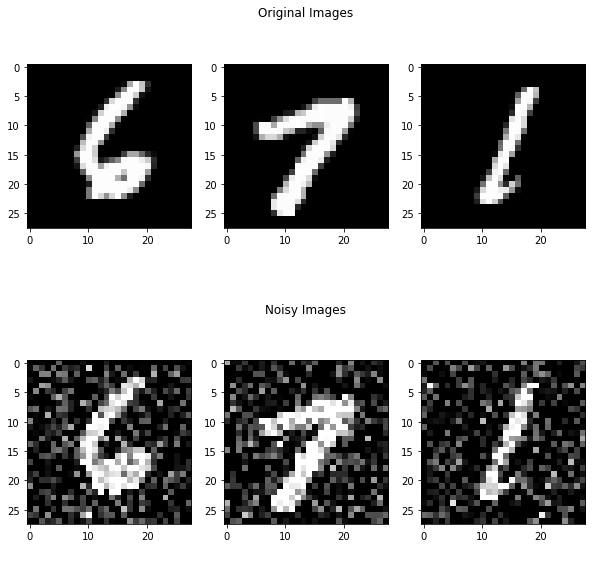

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 

batch_idx, (images_noisy, images_original) = next(enumerate(train_loader))

fig, axes = plt.subplots(2, 3, figsize = (10, 10))
grid = plt.GridSpec(2,1)
titles = ['Original Images', 'Noisy Images']

for i in range(2):
  row = fig.add_subplot(grid[i])
  row.set_title(titles[i])
  row.set_axis_off()

for idx in range(3):
  axes[0][idx].imshow(images_original[idx][0], cmap='gray')
  axes[1][idx].imshow(images_noisy[idx][0], cmap='gray')
#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()

    # encoder
    self.en_conv1 = nn.Conv2d(1, 16, kernel_size=3, padding='same')
    self.en_maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.en_conv2 = nn.Conv2d(16, 8, kernel_size=3, padding='same')
    self.en_maxpool2 = nn.MaxPool2d(kernel_size=2)

    # decoder
    self.de_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding='same')
    self.de_upsample1 = nn.Upsample(scale_factor = 2)
    self.de_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
    self.de_upsample2 = nn.Upsample(scale_factor = 2)
    self.de_conv3 = nn.Conv2d(16, 1, kernel_size=3, padding='same')

  def forward(self, x):
    # encoding layers
    x = x.view(-1, 1, 28, 28)
    x = F.relu(self.en_maxpool1(self.en_conv1(x)))
    x = F.relu(self.en_maxpool2(self.en_conv2(x)))

    #decoding layers
    x = F.relu(self.de_upsample1(self.de_conv1(x)))
    x = F.relu(self.de_upsample2(self.de_conv2(x)))
    x = F.sigmoid(self.de_conv3(x))
    
    return x

AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

In [ ]:
def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images_noisy, images_original) in enumerate(train_loader):

    optimizer.zero_grad()
    images_noisy = images_noisy.to(device)
    images_original = images_original.to(device)
    output = AE(images_noisy)
    loss = loss_fn(output, images_original) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images_noisy)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images_noisy, images_original in test_loader:
      images_noisy = images_noisy.to(device)
      images_original = images_original.to(device)
      output = AE(images_noisy)
      test_loss += loss_fn(output, images_original).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 20

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: [0/60000] Loss: 183.34234619140625
Epoch 1: [6400/60000] Loss: 139.6888885498047
Epoch 1: [12800/60000] Loss: 95.86589050292969
Epoch 1: [19200/60000] Loss: 83.39498901367188
Epoch 1: [25600/60000] Loss: 62.46934509277344
Epoch 1: [32000/60000] Loss: 51.85551452636719
Epoch 1: [38400/60000] Loss: 48.10029983520508
Epoch 1: [44800/60000] Loss: 38.653419494628906
Epoch 1: [51200/60000] Loss: 30.068370819091797
Epoch 1: [57600/60000] Loss: 26.766721725463867
Test result on epoch 1: Avg loss is 24.9104900390625
Epoch 2: [0/60000] Loss: 24.03371810913086
Epoch 2: [6400/60000] Loss: 23.501224517822266
Epoch 2: [12800/60000] Loss: 22.074623107910156
Epoch 2: [19200/60000] Loss: 21.235136032104492
Epoch 2: [25600/60000] Loss: 19.855337142944336
Epoch 2: [32000/60000] Loss: 18.51834487915039
Epoch 2: [38400/60000] Loss: 16.286582946777344
Epoch 2: [44800/60000] Loss: 17.71118927001953
Epoch 2: [51200/60000] Loss: 15.23100757598877
Epoch 2: [57600/60000] Loss: 15.750223159790039
Test re

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


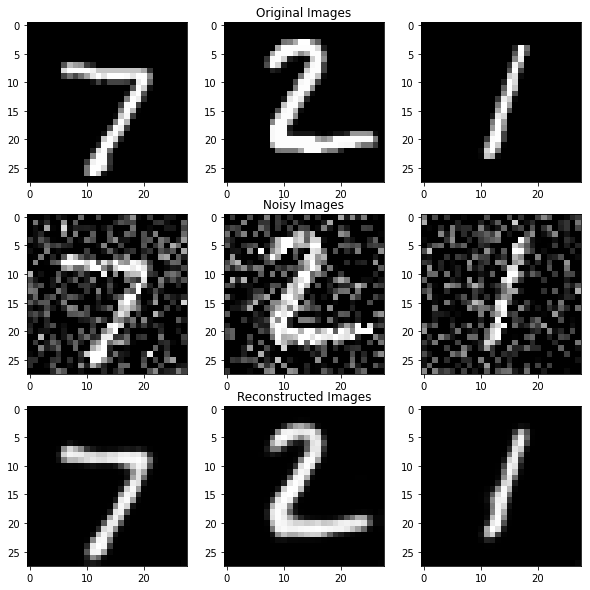

In [ ]:
batch_idx, (images_noisy, images_original) = next(enumerate(test_loader))
images_noisy = images_noisy.to(device)
output = AE(images_noisy).cpu().detach()
images_noisy = images_noisy.cpu()

fig, axes = plt.subplots(3, 3, figsize = (10, 10))
grid = plt.GridSpec(3,1)
titles = ['Original Images', 'Noisy Images', 'Reconstructed Images']

for i in range(3):
  row = fig.add_subplot(grid[i])
  row.set_title(titles[i])
  row.set_axis_off()

for idx in range(3):
  axes[0][idx].imshow(images_original[idx][0], cmap='gray')
  axes[1][idx].imshow(images_noisy[idx][0], cmap='gray')
  axes[2][idx].imshow(output[idx][0], cmap='gray')